In [1]:
%matplotlib inline

import sys
sys.path.append('../')

import bisect
from collections import defaultdict
import datetime
import MySQLdb

from webhealth.analysis import AnalysisHelper
from webhealth.util import datetime_to_mysql_date

db_name='webhealth2'
username='root'
password=''

db = MySQLdb.connect(host='localhost',
                         user=username,
                         passwd=password,
                         db=db_name)

ah = AnalysisHelper(username, password, db_name)

# day one
after_d1 = datetime.datetime(2015, 6, 5, 12, 57)
before_d1 = datetime.datetime(2015, 6, 6, 12, 57)

# day two
after_d2 = datetime.datetime(2015, 6, 6, 12, 57)
before_d2 = datetime.datetime(2015, 6, 7, 12, 57)

In [2]:
def find_failures(after, before):
    print "Finding failures after={} before={}".format(after, before)
    
    node_ids = ah.get_node_ids()
    print "Node ids: {}".format(node_ids)

    # I know that there are two nodes so far
    failed_websites_0 = ah.get_failures(node_ids[0], after=after, before=before)
    print "Number of failed websites {}: {}".format(node_ids[0], len(failed_websites_0))
    failed_websites_1 = ah.get_failures(node_ids[1], after=after, before=before)
    print "Number of failed websites {}: {}".format(node_ids[1], len(failed_websites_1))

    failed = ah.find_failure_intersection(failed_websites_0, failed_websites_1, threshold_sec=60, threshold_occ=10)
    print "Number of failed websites {}".format(len(failed))
    print "Failed websites: {}".format(failed)
    return failed


failures_d1 = find_failures(after_d1, before_d1)

failures_d2 = find_failures(after_d2, before_d2)

Finding failures after=2015-06-05 12:57:00 before=2015-06-06 12:57:00
Node ids: ['aa4f2d96e411', '8b18188b10a7']
Removing:
eyeslipsface.co.uk
yts.re
mymystery.it
kevcowholesale.co.uk
turbotaxonline.ca
porsche.com
banesco.com
cimaglobal.com
gaana.com
medifats.com
hdfclife.com
editorialmanager.com
mediffast.com
muzofon.com
grupobancolombia.com
lifetouchprestige.ca
cosme.net
loccitane.com
mlsmatrix.com
exct.net
axisbiconnect.co.in
grolier.com
tirerack.com
online-tax.net
highrisehq.com
bli.gov.tw
provincial.com
marykay.com.br
autozone.com
sii.cl
viabcp.com
cledepeau-beaute.com
fmlwholesale.co.za
stat.gov.tw
glaciertax.com
kinox.to
mystery-database.com
banquepopulaire.fr
tdscpc.gov.in
marieclaire.com.tw
banesconline.com
mufg.jp
bicentenariobu.com
adtechus.com
paybox.com
fashionising.com
mhealth.ru
ncolonie.org
odishatax.gov.in
bancoestado.cl
movie4k.to
shiseido.co.jp
mexifast.com
Number of failed websites aa4f2d96e411: 119
Removing:
eyeslipsface.co.uk
yts.re
discounttire.com
mymystery.it
ke

In [11]:
import pandas as pd

%matplotlib inline

def plot_value(query, column_name='value', *query_args):
    c = db.cursor()
    c.execute(query, query_args)
    value_res = []
    end_time_res = []
    
    for _ in range(c.rowcount):
        value, end_time = c.fetchone()

        value_res.append(float(value))
        end_time_res.append(end_time)
    c.close()

    df = pd.DataFrame({
            column_name: value_res,
            'time': end_time_res
        })
    return df.plot(x='time', figsize=(16, 12))


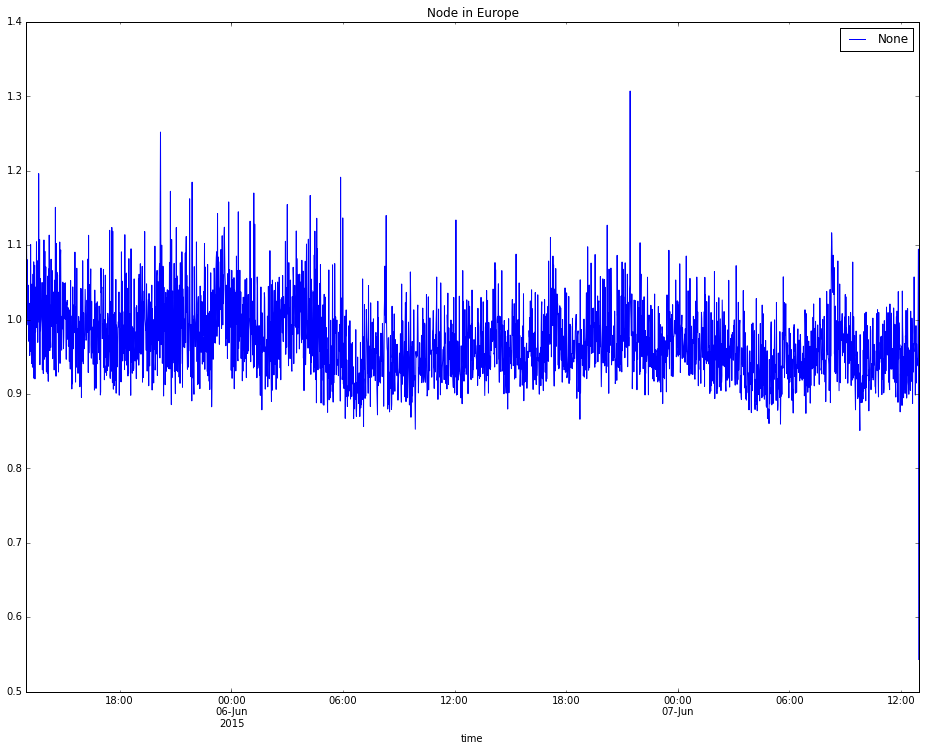

In [12]:
import pandas as pd


def plot_overal_failure_sum_and_duration_avg(node_id, title,
                                             after=datetime.datetime(1900, 1, 1), 
                                             before=datetime.datetime(9999, 1, 1)):
    c = db.cursor()
    c.execute('select avg(duration), sum(failure), end_time_1min from metrics '
              'where node_id=%s and '
              'end_time >= %s and '
              'end_time <= %s '
              'group by end_time_1min',
              (node_id, datetime_to_mysql_date(after), datetime_to_mysql_date(before),))
    duration_res = []
    failure_res = []
    end_time_res = []

    for _ in range(c.rowcount):
        duration, failure, end_time = c.fetchone()

        duration_res.append(float(duration))
        failure_res.append(int(failure))
        end_time_res.append(end_time)
    c.close()

    duration_label = 'avg(duration)'
    failure_label = 'sum(failure)'
    
    df = pd.DataFrame({
            duration_label: duration_res,
            failure_label: failure_res,
            'time': end_time_res
        })
    return df.plot(x='time', y=duration_label, secondary_y=failure_label, title=title, figsize=(16, 12))


plot_overal_failure_sum_and_duration_avg('8b18188b10a7', 'Node in Europe', after_d1, before_d2)

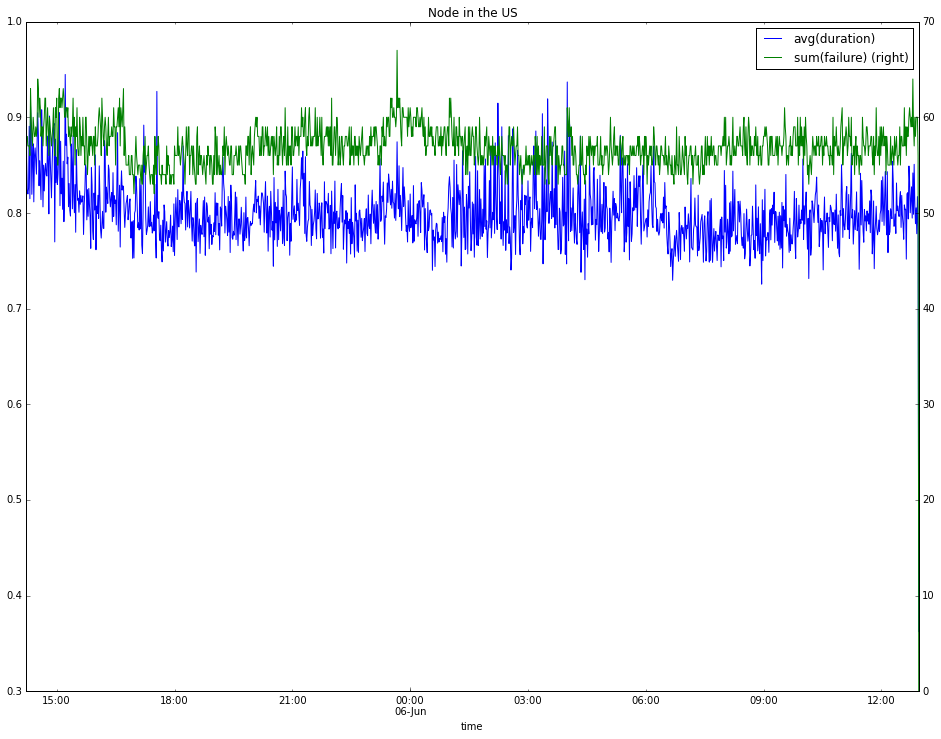

In [3]:
plot_overal_failure_sum_and_duration_avg('aa4f2d96e411', 'Node in the US', after, before)

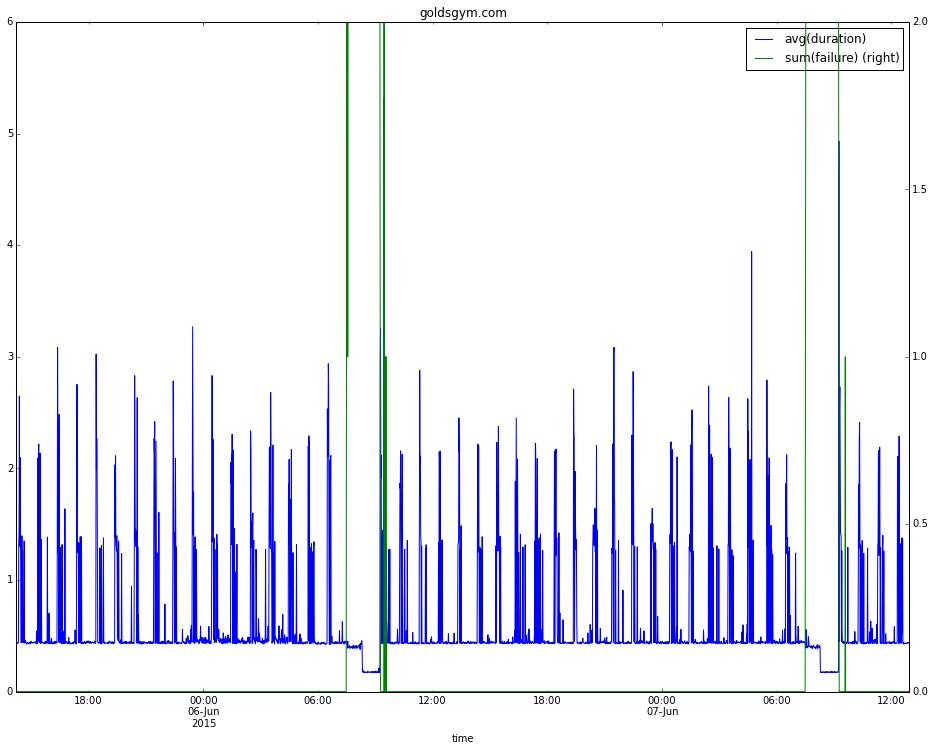

In [18]:
after_for_plot = datetime.datetime(2015, 6, 5, 12, 57)
before_for_plot = datetime.datetime(2015, 6, 7, 12, 57)

ah.plot_duration_and_failure('goldsgym.com', after_for_plot, before_for_plot)

In [7]:
# let's get overal failure rate

# this were obtained by putting print statement in the failure finding algorithm
ignore = ['adtechus.com', 'autozone.com', 'axisbiconnect.co.in', 'bancoestado.cl', 'banesco.com', 'banesconline.com', 'banquepopulaire.fr', 'bicentenariobu.com', 'birchbox.com', 'bli.gov.tw', 'cimaglobal.com', 'cledepeau-beaute.com', 'cosme.net', 'discounttire.com', 'editorialmanager.com', 'exct.net', 'eyeslipsface.co.uk', 'fashionising.com', 'fmlwholesale.co.za', 'gaana.com', 'glaciertax.com', 'grolier.com', 'grupobancolombia.com', 'hdfclife.com', 'highrisehq.com', 'kevcowholesale.co.uk', 'kinogo.net', 'kinox.to', 'lafitness.com', 'lifetouchprestige.ca', 'loccitane.com', 'marieclaire.com.tw', 'marketforce.com', 'marykay.com.br', 'medifats.com', 'mediffast.com', 'mexifast.com', 'mhealth.ru', 'mlsmatrix.com', 'movie4k.to', 'mufg.jp', 'muzofon.com', 'mymystery.it', 'mystery-database.com', 'ncolonie.org', 'odishatax.gov.in', 'online-tax.net', 'osinka.ru', 'paybox.com', 'porsche.com', 'provincial.com', 'redbox.com', 'santander.cl', 'seilin-wholesale.com', 'servicequality.us', 'shiseido.co.jp', 'sii.cl', 'stat.gov.tw', 'tdscpc.gov.in', 'tirerack.com', 'turbotaxonline.ca', 'viabcp.com', 'yts.re', 'zamunda.net', 'zone-telechargement.com']
ignore = '"' + '", "'.join(ignore) + '"'

c = db.cursor()
c.execute('select count(*) from metrics where website not in (%s) and '
          'failure=0 and '
          'end_time >= %s and '
          'end_time <= %s', 
          (ignore, datetime_to_mysql_date(after_d1), datetime_to_mysql_date(before_d2),))
success_probes = int(c.fetchone()[0])

c = db.cursor()
c.execute('select count(*) from metrics where website not in (%s) and '
          'failure=1 and '
          'end_time >= %s and '
          'end_time <= %s', 
          (ignore, datetime_to_mysql_date(after_d1), datetime_to_mysql_date(before_d2),))
failure_probes = int(c.fetchone()[0])

print "Failure rate {}".format(1.0 * failure_probes / success_probes)

Failure rate 0.0639177611892
